# How to encode a data-grid with STARE (sidecars).
Previously we worked with lists of vertices in the form of simple polygons. It is also possible to encode an entire data-grid using `STARE` and then use `pySTARE` or `STAREpandas` to operate on the results.

In this case we will encode the MERRA-2 data-grid using the [STAREMaster](https://github.com/SpatioTemporal/STAREMaster_py) utility.

    MERRA-2 NATIVE RESOLUTION
        0.5 x 0.625 centered on (-180, -90)
       
        nlon = 576
        nlat = 361
       
        dlon = 0.625 deg
        dlat = 0.5 deg


In [1]:
# Standard Imports

# Third-Party Imports
import numpy as np
import numpy.ma as ma
from shapely.geometry import Polygon, Point, LineString, GeometryCollection, mapping
import geopandas
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.colors as mcolors
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask

# STARE Imports
import pystare
import starepandas
import staremaster
# ------------------------------------------------------------------------------

LON_180 = lambda x: ((x + 180.0) % 360.0) - 180.0
LON_360 = lambda x: ((x + 360.0) % 360.0)

`STAREpandas` uses [Dask](https://docs.dask.org/en/stable/index.html) to handle parallel and distributed computing. In our case we set things up for a single CPU with `NCORES`. If we were using a cluster we could set `NCPU` to a higher value for even better performance.

In [2]:
##
# Tell Dask to and how to use its resources
dask.config.set(scheduler='processes')

##
# Options for Dask and multiprocessing
# ------------------------------------
#   `NCPU` is passed to STARE tools for a parameter `n_partitions`.
#        n_partitions: Internally, a Dask DataFrame is split into n_partitions, where each partition is one Pandas DataFrame.
#                      These DataFrames are split vertically along the index (i.e., a row).
#   `NCORES` is passed to STARE tools for a parameter `n_workers`.
#        n_workers   : Number of processor cores to use with Dask
NCPU = 1
NCORES = 6

**Author:** [Mike Bauer](mbauer@bayesics.com)

In [ ]:
##
# Path to save MERRA2 sidecar
MERRA2_GRANULE_PATH = "."

##
# Load MERRA-2 Grandule
merra2_granule = staremaster.products.MERRA2(as_mcms=0)

merra2_granule.get_latlon()
merra2_lats = merra2_granule.lats
print(f"MERRA-2 Lats {merra2_lats.shape}: [{merra2_lats[0, 0]:+8.3f}, {merra2_lats[1, 0]:+8.3f} ... {merra2_lats[-2, 0]:+8.3f}, {merra2_lats[-1, 0]:+8.3f}]")

merra2_lons = merra2_granule.lons
print(f"MERRA-2 Lons {merra2_lons.shape}: [{merra2_lons[0, 0]:+8.3f}, {merra2_lons[0, 1]:+8.3f} ... {merra2_lons[0, -2]:+8.3f}, {merra2_lons[0, -1]:+8.3f}]")

merra2_nlons = merra2_lats.shape[1]
merra2_nlats = merra2_lats.shape[0]
merra2_lons_1d = merra2_lons[0, :]
merra2_lats_1d = merra2_lats[:, 0]

##
# Create sidecar
make_sidecar = [False, True][0]
if make_sidecar:
    merra2_granule.create_sidecar(out_path=f"{MERRA2_GRANULE_PATH}")

MERRA-2 Lats (361, 576): [ -90.000,  -89.500 ...  +89.500,  +90.000]
MERRA-2 Lons (361, 576): [-180.000, -179.375 ... +178.750, +179.375]


This takes about 5m and results in three sidecar files: 

1) `merra2_sids.pkl`
2) `merra2_sidecar_stare.nc`
3) `merra2_cover_sids.pkl`

```text
File type: Hierarchical Data Format, version 5

---

netcdf merra2_sidecar_stare.nc {
  dimensions:
    i = 361;
    l = 158404;
    j = 576;
  variables:
    ulong STARE_cover(l=158404);
      :long_name = "SpatioTemporal Adaptive Resolution Encoding (STARE) cover";
      :_ChunkSizes = 158404U; // uint
     
    float Latitude(i=361, j=576);
      :long_name = "Latitude";
      :units = "degrees_north";
      :_ChunkSizes = 361U, 576U; // uint

    float Longitude(i=361, j=576);
      :long_name = "Longitude";
      :units = "degrees_east";
      :_ChunkSizes = 361U, 576U; // uint

    ulong STARE_index(i=361, j=576);
      :_FillValue = 0UL; // ulong
      :long_name = "SpatioTemporal Adaptive Resolution Encoding (STARE) index";
      :_ChunkSizes = 361U, 576U; // uint

  // global attributes:
}
```
Once the sidecar files are created we can simply fetch/read the SIDs array from these files without the computational expenses of creating them.

MERRA-2 SIDs (361, 576): [2287822011494832618, 2287822011494832618 ... 2287822011494832618, 2287822011494832618]
MERRA-2 Cover SIDs (158404,): [8, 35184372088840 ... 4610041149032235016, 4610058741218279432]


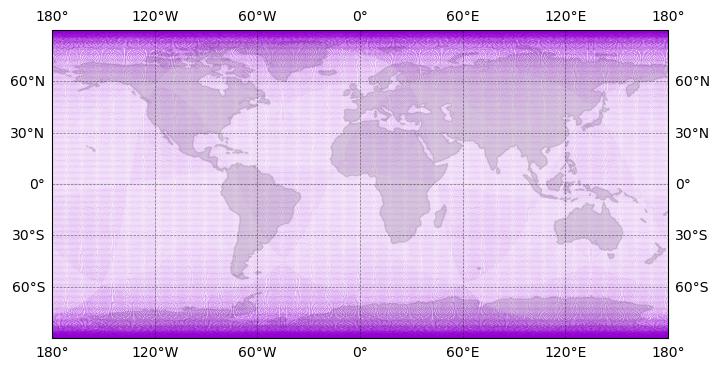

In [ ]:
##
# Fetch SIDs and cover
merra2_granule.get_sids(out_path=f"{MERRA2_GRANULE_PATH}")
print(f"MERRA-2 SIDs {merra2_granule.sids.shape}: [{merra2_granule.sids[0, 0]:d}, {merra2_granule.sids[0, 1]:d} ... {merra2_granule.sids[0, -2]:d}, {merra2_granule.sids[0, -1]:d}]")

merra2_granule.get_cover(out_path=f"{MERRA2_GRANULE_PATH}")
print(f"MERRA-2 Cover SIDs {merra2_granule.cover_sids.shape}: [{merra2_granule.cover_sids[0]:d}, {merra2_granule.cover_sids[1]:d} ... {merra2_granule.cover_sids[-2]:d}, {merra2_granule.cover_sids[-1]:d}]")

geom = geopandas.GeoSeries([Point(x, y) for x, y in zip(merra2_lons.flatten(), merra2_lats.flatten())])
merra2_grids = [_ for _ in range(merra2_nlats * merra2_nlons)]
merra2_spdf = starepandas.STAREDataFrame({'crs': 'EPSG:4326', 'geometry': geom, 'lons': merra2_lons.flatten(),
                                          'lats': merra2_lats.flatten(), 'sids': merra2_granule.sids.flatten(),
                                          'grids': merra2_grids}, n_partitions=NCPU)
##
# Add Trixels
_trixels = merra2_spdf.make_trixels(sid_column='sids', wrap_lon=False, n_partitions=NCPU, num_workers=NCORES)
merra2_spdf.set_trixels(_trixels, inplace=True)

##
# Make Figure
# --------------------------------------------------------------------------
map_extent = [-180, 180, -90, 90]
lon_0_global = 0.0

# WGS-84 Earth equatorial radius at sea level (meters)
globe = ccrs.Globe(datum='WGS84', ellipse='WGS84')

# Geodetic:
#   A 3D/spherical CRS based on latitude and longitude where geographical distance and coordinates are measured in degrees.
geod_crs = ccrs.Geodetic(globe=globe)

# PlateCarree Projection (AKA Equirectangular or Equidistant Cylindrical):
#   A 2D CRS with a flat topology and Euclidean distance (m).
flat_crs = ccrs.PlateCarree(central_longitude=lon_0_global, globe=globe)

fig = plt.figure(figsize=(12, 4), frameon=True)
geo_axes = plt.axes(projection=flat_crs)
geo_axes.set_extent(map_extent, flat_crs)
geo_axes.add_feature(cfeature.LAND, color='grey', alpha=0.25)
gl = geo_axes.gridlines(draw_labels=True, linewidth=.5, color='k', alpha=0.5, linestyle='--')

merra2_spdf.plot(trixels=True, boundary=True, ax=geo_axes, figsize=(12, 4), aspect=None, zorder=1,
                 linewidth=0.25, color="darkviolet", alpha=0.6, transform=geod_crs)


plt.show()

These now can act as a lookup-table mapping MERRA-2 data-grid i,j indices to their `STARE` index. Note we also extracted what we call a `STARE` cover, which is a dissolve operation (i.e., union simplification) of the SIDs to the the fewest aggregate SIDs that capture the entire coverage of the original SIDs using the fewest/largest trixels (see image below). For example, while the SIDs in `merra2_granule.sids` are all Q-level 10, those in `merra2_granule.cover_sids` range from Q-levels 8 to 10 (10 to 40 km).

<img width="40%" alt="dissolve.png" src="dissolve.png" style="border-radius: 15%">

<img width="40%" alt="STARE_index_in_merra2_sidecar_stare2.png" src="STARE_index_in_merra2_sidecar_stare2.png" style="border-radius: 15%">

This cover can then be used for things like intersection and `STARE` will automatically adjust the level/resolution of the two sets of trixels to put them on equal footing before the intersection check. Here we'll use `pySTARE` to do the intersection and plot the trixels in the same way done above (code not shown).


Polygon-A SIDs: [3643412098542731268 3659174697238528004 3668181896493268996 ...
 4285041454780252170 4285042004536066058 4285042554291879946]

Q-10 MERRA-2 intersection with Poly-A (1565): [3640034398822203400, 3640060787101270024, ... 4285042554291879946]


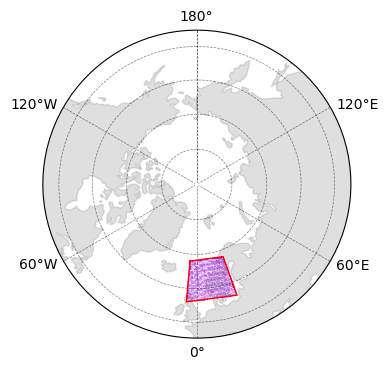

In [10]:
##
# Example Polygon Vertices
geo_lons_180 = [-5.0, -5.0, 20.0, 20.0]
geo_lats = [68.0, 56.0, 56.0, 68.0]

##
# Form polygon (refered to as Polygon-A)
verts_180 = [(float(geo_lons_180[_]), float(geo_lats[_])) for _ in range(len(geo_lons_180))]
poly_180 = Polygon(verts_180)

##
# Create a STARE DataFrames
q_level = 10
spdf = starepandas.STAREDataFrame({'lons': geo_lons_180, 'lats': geo_lats, 'geometry': poly_180},
                                  add_sids=True, level=q_level, add_trixels=True, n_partitions=NCPU)

##
# Find the SIDs for polygon-A
polya_sids = spdf['sids'].iloc[0]
print(f"\nPolygon-A SIDs: {polya_sids}")

##
# Find the MERRA-2 SIDs for polygon-A
union_merra2a = pystare.intersection(polya_sids, merra2_granule.cover_sids, multi_resolution=False)
print(f"\nQ-{q_level:02d} MERRA-2 intersection with Poly-A ({len(union_merra2a)}): [{union_merra2a[0]}, {union_merra2a[1]}, ... {union_merra2a[-1]}]")

map_extent = [-180, 180, 45, 90]
lon_0_global = 0.0

# WGS-84 Earth equatorial radius at sea level (meters)
globe = ccrs.Globe(datum='WGS84', ellipse='WGS84')

# Geodetic:
#   A 3D/spherical CRS based on latitude and longitude where geographical distance and coordinates are measured in degrees.
geod_crs = ccrs.Geodetic(globe=globe)

# PlateCarree Projection (AKA Equirectangular or Equidistant Cylindrical):
#   A 2D CRS with a flat topology and Euclidean distance (m).
flat_crs = ccrs.PlateCarree(central_longitude=lon_0_global, globe=globe)

# Lambert Azimuthal Equal-Area
#   A 2D CRS centered on (map_lat0, map_lon0), which is then the zero point of the flat topology w/ Euclidean distance (m).
polar_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=lon_0_global, central_latitude=90.0)

fig = plt.figure(figsize=(12, 4), frameon=True)
geo_axes = plt.axes(projection=polar_crs)
geo_axes.set_extent(map_extent, flat_crs)
geo_axes.add_feature(cfeature.LAND, color='grey', alpha=0.25)
gl = geo_axes.gridlines(draw_labels=True, linewidth=.5, color='k', alpha=0.5, linestyle='--')

geo_axes.plot(*poly_180.exterior.xy, 'r-', linewidth=1, markersize=1, transform=geod_crs)

##
# Just intersection
sdf_ = starepandas.STAREDataFrame(sids=union_merra2a)
spf_trixels = sdf_.make_trixels(wrap_lon=False)
sdf_.set_trixels(spf_trixels, inplace=True)
sdf_.plot(trixels=True, boundary=True, ax=geo_axes, figsize=(12, 4), aspect=None, zorder=1,
          linewidth=0.25, color="darkviolet", alpha=0.6, transform=geod_crs)

##
# Trim plot
theta = np.linspace(0.0, 2.0 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
geo_axes.set_boundary(circle, transform=geo_axes.transAxes)

plt.show()

In [11]:
def grid2ij(gridid):
    """Returns the 2D grid indexes of an im, jm zero-indexed, row-major array, given a 1D index (gridid) for an array of the same size.

    Args:
        gridid (int): The gridID of interest (enumerated source grid)
        im (int): The number of longitude grids in the source grid
        jm (int): The number of latitude grids in the source grid

    Returns:
        idx (int): The longitude index of the desired gridID
        jdx (int): The latitude index of the desired gridID
    """
    im = 576
    jm = 361
    ngrd = 207936
    if isinstance(gridid, list):
        retvals = []
        for gid in gridid:
            retvals.append((gid % im, gid // im))
        return retvals
    else:
        if 0 <= gridid < ngrd:
            return gridid % im, gridid // im
        else:
            raise ValueError(f"GridID {gridid} is outside of indexing 0:{ngrd - 1}")

def ij2grid(j: int, i: int, im: int, jm: int) -> int:
    """Returns 1d grid index of an jm,im 'row-major' array.
        i the 'x' index between 0 , im-1 where im is index max
        j the 'y' index between 0 , jm-1 where jm is index max
    """
    k = None
    if i < im and j < jm:
        k = j * im + i
    if k is None:
        raise ValueError(f"Error in ij2grid(): j = {j:d}, i = {i:d} im = {im:d} jm = {jm:d}")
    return int(k)

def fix_lon_lat_for_pcolormesh(in_lons, in_lats):
    """https://bairdlangenbrunner.github.io/python-for-climate-scientists/matplotlib/pcolormesh-grid-fix.html"""
    # extend longitude by 2
    lon_extend = np.zeros(in_lons.size + 2)
    # fill in internal values
    lon_extend[1:-1] = in_lons  # fill up with original values
    # fill in extra endpoints
    lon_extend[0] = in_lons[0] - np.diff(in_lons)[0]
    lon_extend[-1] = in_lons[-1] + np.diff(in_lons)[-1]
    # calculate the midpoints
    lon_pcolormesh_midpoints = lon_extend[:-1] + 0.5 * (np.diff(lon_extend))
    # extend latitude by 2
    lat_extend = np.zeros(in_lats.size + 2)
    # fill in internal values
    lat_extend[1:-1] = in_lats
    # fill in extra endpoints
    lat_extend[0] = in_lats[0] - np.diff(in_lats)[0]
    lat_extend[-1] = in_lats[-1] + np.diff(in_lats)[-1]
    # calculate the midpoints
    lat_pcolormesh_midpoints = lat_extend[:-1] + 0.5 * (np.diff(lat_extend))
    # Don't extend beyond poles
    lat_pcolormesh_midpoints = np.where(lat_pcolormesh_midpoints > 90.0, 90.0, lat_pcolormesh_midpoints)
    lat_pcolormesh_midpoints = np.where(lat_pcolormesh_midpoints < -90.0, -90.0, lat_pcolormesh_midpoints)
    return lon_pcolormesh_midpoints, lat_pcolormesh_midpoints

##
# Fetch MERRA-2 data-grids for intersection
coerced_sids = pystare.spatial_coerce_resolution(union_merra2a, q_level)
union_merra2a_coerced_sids = pystare.spatial_clear_to_resolution(coerced_sids)
# union_merra2a_coerced_sids = pystare.spatial_coerce_resolution(union_merra2a, q_level)
print(f"Q-{q_level:02d} union_merra2a_coerced_sids ({len(union_merra2a_coerced_sids)}): [{union_merra2a_coerced_sids[0]}, {union_merra2a_coerced_sids[1]}, ... {union_merra2a_coerced_sids[-1]}]")

merra2_nlons = merra2_lats.shape[1]
merra2_nlats = merra2_lats.shape[0]
merra2_sids = np.reshape(merra2_granule.sids, merra2_nlats * merra2_nlons)
coerced_sids = pystare.spatial_coerce_resolution(merra2_sids, q_level)
merra2_sids_coerced_sids = pystare.spatial_clear_to_resolution(coerced_sids)
# merra2_sids_coerced_sids = pystare.spatial_coerce_resolution(merra2_sids, q_level)
print(f"Q-{q_level:02d} merra2_sids_coerced_sids ({len(merra2_sids_coerced_sids)}): [{merra2_sids_coerced_sids[0]}, {merra2_sids_coerced_sids[1]}, ... {merra2_sids_coerced_sids[-1]}]")

union_merra2a_grids = set()
for kidx in range(merra2_nlats * merra2_nlons):
    # grid_sids = merra2_granule_sids1d[kidx]
    grid_sids = merra2_sids_coerced_sids[kidx]
    # print(f"{kidx}: {grid_sids}")
    if grid_sids in union_merra2a:
        union_merra2a_grids.add(kidx)
union_merra2a_grids = sorted(list(union_merra2a_grids))
print(f"Polygon-A MERRA-2 Grids ({len(union_merra2a_grids)}): [{union_merra2a_grids[0]}, {union_merra2a_grids[1]}, ... {union_merra2a_grids[-1]}]")

Q-10 union_merra2a_coerced_sids (1565): [3640034398822203402, 3640060787101270026, ... 4285042554291879946]
Q-10 merra2_sids_coerced_sids (207936): [2287821463878631434, 2287821463878631434, ... 4017203720788901898]
Polygon-A MERRA-2 Grids (66): [168472, 168511, ... 182892]


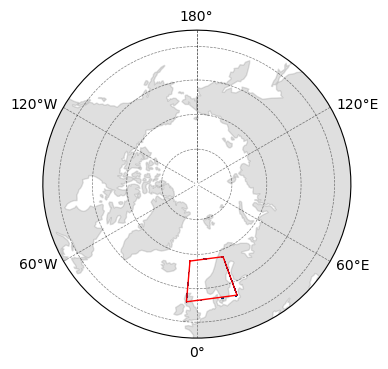

In [12]:

fig = plt.figure(figsize=(12, 4), frameon=True)
geo_axes = plt.axes(projection=polar_crs)
geo_axes.set_extent(map_extent, flat_crs)
geo_axes.add_feature(cfeature.LAND, color='grey', alpha=0.25)
gl = geo_axes.gridlines(draw_labels=True, linewidth=.5, color='k', alpha=0.5, linestyle='--')

geo_axes.plot(*poly_180.exterior.xy, 'r-', linewidth=1, markersize=1, transform=geod_crs)

tmp_lon_1d = merra2_lons[0, :]
tmp_lat_1d = merra2_lats[:, 0]

plon_mid, plat_mid = fix_lon_lat_for_pcolormesh(tmp_lon_1d, tmp_lat_1d)
x_lon, y_lat = np.meshgrid(plon_mid, plat_mid)

merra2_hits = np.zeros((merra2_nlats, merra2_nlons), dtype=int)
for grd in union_merra2a_grids:
    iidx, jidx = grid2ij(grd)
    merra2_hits[jidx, iidx] = 1.0
    # print(f"{grd} (i {iidx}, j {jidx}) {plat_mid[jidx]:+8.3f}, {plon_mid[iidx]:+8.3f}")
merra2_hits = ma.masked_equal(merra2_hits, 0)
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
param_dict = {"cmap": cm.Blues_r, "alpha": 1, "shading": 'nearest', "edgecolors": 'None'}
plt.pcolormesh(x_lon, y_lat, merra2_hits, transform=flat_crs, zorder=1, **param_dict)

# Trim plot
theta = np.linspace(0.0, 2.0 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
geo_axes.set_boundary(circle, transform=geo_axes.transAxes)

plt.show()

<img width="25%" alt="merra2_polyAgrids.png" src="merra2_polyAgrids.png" style="border-radius: 15%">


**Last update:** 03-April-2025 (Created: 04-April-2025)